In [1]:
!pip install tensorflow

In [2]:
!pip install imageio


In [3]:
!pip install tensorflow imageio tensorflow-docs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 8.9 MB/s eta 0:00:00


In [4]:
import glob
import imageio
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

In [5]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
train_images.shape[0]

60000

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float')
train_images = (train_images - 127.5) / 127.5

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
element = next(iter(train_dataset))
print(element.shape) # This will print the shape of a batch of images from the dataset.

(256, 28, 28, 1)


In [11]:
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>


In [12]:
noise = tf.random.normal([1,100])

In [13]:
print(len(noise[0]))

100


In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape == (None,28,28,1)
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


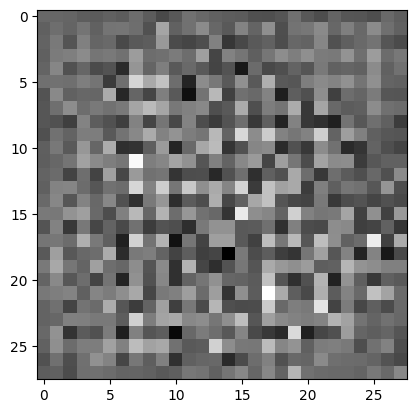

In [15]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00047746]], shape=(1, 1), dtype=float32)


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [19]:
def discriminator_loss(real_ouputm, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_ouputm),real_ouputm)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_dirs = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dirs,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [23]:
EPOCHS =100
noise_dim = 100
num_example_to_generate = 16
seed = tf.random.normal([num_example_to_generate,noise_dim])

In [24]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        gradient_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))

In [25]:
def train(dataset,epcohs):
    for epoch in range(epcohs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print('saved at epoch {}'.format(epoch+1))
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))
        display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [26]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input,training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

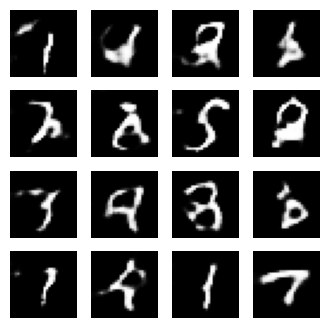

Time for epoch 33 is 12.596840381622314 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dirs))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
